### SPARK: TIME ANALYSIS

## Description
3 studies on the data provided in the file tripdata_2017_01.csv
    1. Average speed of taxis in terms of the hour
    2. Most common taxi trips
    3. Financial records (tips, persons, etc)
We are going to use Spark's API (RDDs), dataframes and direct SQL to analyze several studies:
1. **Average speed of taxis in terms of the hour:** we calculate the average speed of taxis by the hour of the day. Using the trip pickup and drop-off times along with the trip distance, we determine the speed for each trip. By grouping the data by hour, we can observe traffic patterns throughout the day, identifying peak hours when taxi speeds are lower due to heavy traffic, and non-peak hours when speeds are higher.
2. **Most common taxi trips:** this study identifies the most frequent taxi routes in New York City. By analyzing the pickup and drop-off locations, we determine which trips are most common. This helps in understanding the most popular areas for taxi services, as well as identifying potential high-demand zones during specific times of the day.
3. **Financial records: Average tips per borough:** we examine the financial aspects of taxi trips by focusing on tips provided by passengers. By grouping the data by borough, we calculate the average tip per trip in each borough. This study provides insights into the tipping behavior across different regions of New York, highlighting which boroughs tend to receive higher or lower tips.
4. **Financial records: Average taxi fare per hour:** we focus on the average fare amount per hour. By grouping the data based on the pickup time, we calculate the average fare during different hours of the day. This analysis reveals how fare amounts fluctuate throughout the day, which could be influenced by demand, traffic, or passenger behavior.

A part from this, we also have calculated the execution time, mount of data processed and processing speed. We have done graphical representation for all the studies so it's clear to understand the analysis.

#### **Setup**

Here we initialize the environment of Apache Spark and we load the dataset we are going to use. We specify the number os cores we are using with "local[*]". In our case we have done the project with a 10 cores pc.
It's important to comment that the dataset is a .parquet file and we have introduced a specific command to read it.

In [1]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark
from pyspark.sql import SparkSession

#we are going to crate a SparkSession with the name "lab_spark"
spark = SparkSession.builder.appName("lab_spark").master("local[8]").getOrCreate()#the * means we are using all the cores

#obtain the SparkContext from the SparkSession
spark_context = spark.sparkContext

#libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle

#import functions and classes from pyspark.sql
from pyspark.sql.functions import col, avg, round,concat,lit, expr, from_unixtime, unix_timestamp, date_format, count
from pyspark.sql.types import IntegerType #module to work with integer data types

In [3]:
#we need to calculate the time it takes to read the data
start_time = time.time()

Now, we are going to read the dataset of the taxis

In [4]:
#this is for the CSV attached in the assignment
#taxi_data_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("mode", "PERMISSIVE").load(r"./tripdata_2017_01.csv") 
#taxi_data_df.show(5)

#this is with the final CSV (parquet file)
taxi_data_df = spark.read.parquet('yellow_tripdata_2024-01.parquet')
taxi_data_df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [5]:
end_time = time.time()
time_to_read=(end_time - start_time)#time it takes to read the data

In [6]:
print('Time it takes to read the data with Spark dataframes: ', time_to_read)

Time it takes to read the data with Spark dataframes:  1.9594268798828125


In [7]:
#taxi_data_df.describe().show()

#### **Data cleanining**

In [8]:
#we need to calculate the time it takes to clean the data
start_time = time.time()

We are going to calculate the total duration of each trip and remove the ones that have a duration of 0

In [9]:
taxi_data_df = taxi_data_df.withColumn("trip_time_hours", round((unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 3600, 2)) #calculate the trip time in hours
taxi_data_df = taxi_data_df.filter(col('trip_time_hours') >= 0)

In [10]:
#now let's count how many of them do we have

In [11]:
taxi_data_df.count()

2964587

We are going to remove rows <=0 (tip_amount, total_amount, fare_amount, mta_tax)

In [12]:
#filter values of tips and other taxes lower than 0

#for column in ["tip_amount", "tolls_amount", "improvement_surcharge", "total_amount"]:
    #taxi_data_df = taxi_data_df.filter(col(column) >= 0)
#¡¡¡¡¡¡¡¡DUDA DE SI total_amount Y fare_amount SOLO DESCARTAR LOS >0 Y DEJAR LOS =0!!!!!!!!!!!!!!!!!

for column in ['tip_amount', 'mta_tax']:
    taxi_data_df = taxi_data_df.filter(taxi_data_df[column] >= 0)

In [13]:
for column in ['fare_amount', 'total_amount']:
        taxi_data_df = taxi_data_df.filter(taxi_data_df[column] > 0)

In [14]:
taxi_data_df.count()

2926246

In [15]:
end_time = time.time()
time_data_cleaning = end_time - start_time#time it takes to clean the data
print('Time it takes to clean the data with Spark dataframes: ', time_data_cleaning)

Time it takes to clean the data with Spark dataframes:  3.857072591781616


### **STUDY 1: AVERAGE SPEED OF TAXIS IN TERMS OF THE HOUR**

In this study, we will calculate the average speed of New York taxis for each hour of the day to analyze traffic patterns in the city. This analysis has been conducted using dataframes, RDD, SQL, and Pandas. The steps we followed are as follows:

    1. Convert trip distance from miles to kilometers.
    2. Calculate speed by dividing the trip distance by the previously calculated trip duration.
    3. Group the data by the hour of the day and compute the average speed.
    4. Finally, we plot the results.

**With RDD**

Here we are using RDDs (Resilient Distributed Datasets). RDDs offer a robust framework for distributed data processing, enabling efficient handling of large datasets while ensuring fault tolerance and supporting parallel computation.

In [16]:
taxi_df = taxi_data_df.alias('taxi_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|

In [17]:
#function to calculate the time elapsed in hours to know the duration of the trips
def calculate_elapsed_hours(start_time, end_time):
    time_diff = (end_time - start_time).total_seconds() / 3600
    return np.round(time_diff, 3)

In [18]:
# Select required columns once instead of multiple times
taxi_rdd = taxi_df.select('trip_distance', 'tpep_pickup_datetime', 'tpep_dropoff_datetime').rdd.map(lambda row: (row[0], row[1], row[2]))

# Convert trip distance to kilometers and calculate trip duration in hours in one step
distance_time_rdd = taxi_rdd.map(lambda x: (np.round(x[0] * 1.609344, 3), calculate_elapsed_hours(x[1], x[2]), x[1]))

# Calculate speed and extract hour from pickup time in the same step
speed_hour_rdd = distance_time_rdd.map(lambda x: (
    np.round(x[0] / x[1], 3) if x[1] > 0 else 0,  # Speed in km/h
    x[2].hour                                     # Extract hour from pickup time (x[2] is pickup time)
))

# Filter out zero-speed trips
speed_hour_rdd = speed_hour_rdd.filter(lambda x: x[0] > 0)

# Combine total speed and trip count for each hour in one pass using mapValues and reduceByKey
hour_speed_count_rdd = speed_hour_rdd.map(lambda x: (x[1], (x[0], 1))) \
                                     .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

# Calculate average speed per hour
avg_speed_per_hour_rdd = hour_speed_count_rdd.map(lambda x: (x[0], np.round(x[1][0] / x[1][1], 3)))

# Collect results
start_time = time.time()
avg_speed_per_hour_list = avg_speed_per_hour_rdd.collect()

# Amount of data processed
data_processed = taxi_rdd.count()  # Count total records processed


end_time = time.time()
execution_time = end_time - start_time

processing_speed = data_processed / execution_time if execution_time > 0 else float('inf')

# Print the result
for hour, avg_speed in sorted(avg_speed_per_hour_list):
    print(f'Hour: {hour}, Avg Speed: {avg_speed} km/h')

print(f'Execution time for Spark RDD task: {execution_time:.2f} seconds')
print(f'Amount of data processed: {data_processed} records')
print(f"Processing Speed: {processing_speed:.2f} records/second")

Hour: 0, Avg Speed: 25.196 km/h
Hour: 1, Avg Speed: 24.555 km/h
Hour: 2, Avg Speed: 22.947 km/h
Hour: 3, Avg Speed: 24.872 km/h
Hour: 4, Avg Speed: 32.142 km/h
Hour: 5, Avg Speed: 62.059 km/h
Hour: 6, Avg Speed: 93.609 km/h
Hour: 7, Avg Speed: 52.319 km/h
Hour: 8, Avg Speed: 27.091 km/h
Hour: 9, Avg Speed: 18.291 km/h
Hour: 10, Avg Speed: 19.766 km/h
Hour: 11, Avg Speed: 20.991 km/h
Hour: 12, Avg Speed: 19.418 km/h
Hour: 13, Avg Speed: 17.383 km/h
Hour: 14, Avg Speed: 19.607 km/h
Hour: 15, Avg Speed: 20.148 km/h
Hour: 16, Avg Speed: 17.164 km/h
Hour: 17, Avg Speed: 16.738 km/h
Hour: 18, Avg Speed: 17.164 km/h
Hour: 19, Avg Speed: 19.229 km/h
Hour: 20, Avg Speed: 21.453 km/h
Hour: 21, Avg Speed: 22.101 km/h
Hour: 22, Avg Speed: 22.558 km/h
Hour: 23, Avg Speed: 25.12 km/h
Execution time for Spark RDD task: 39.73 seconds
Amount of data processed: 2926246 records
Processing Speed: 73656.56 records/second


In [19]:
first_values = [x[0] for x in avg_speed_per_hour_list]

# Second list for the second elements (average speeds)
second_values = [x[1] for x in avg_speed_per_hour_list]

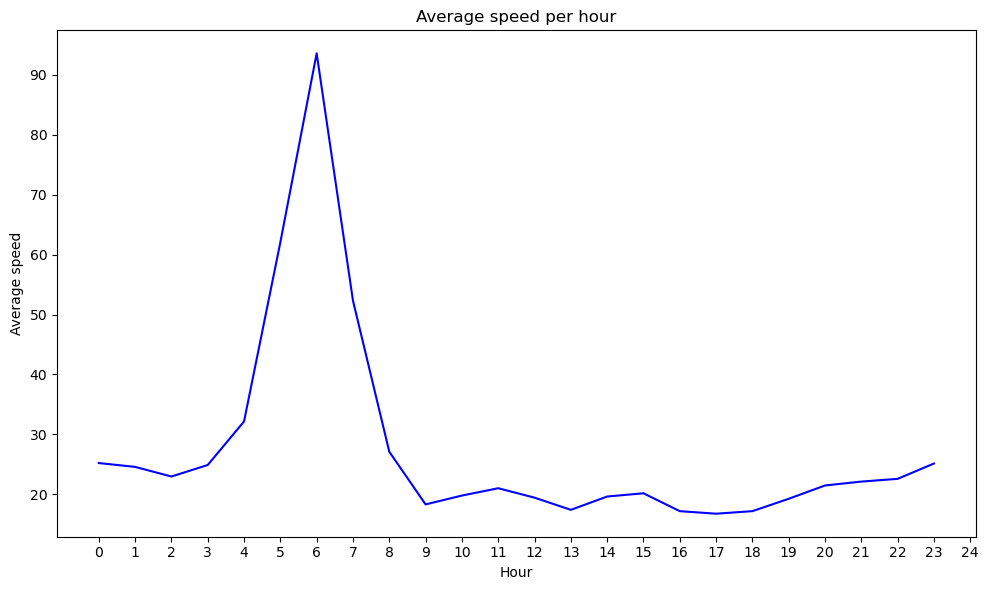

In [20]:
# Initialize a new figure with a defined size (10 inches wide by 6 inches tall)
fig, ax = plt.subplots(figsize=(10, 6))

#line plot, using hours for the x-axis and average speed for the y-axis
sns.lineplot(x=first_values, y=second_values, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average speed")
ax.set_title("Average speed per hour")
ax.set_xticks(range(25))
ax.set_xticklabels(range(25), rotation=0)

plt.tight_layout()
plt.show()

**With dataframes**

In this section, we will use PySpark DataFrames to perform the analysis. DataFrames offer a higher-level abstraction for distributed data processing, simplifying the handling of structured data and enabling execution optimizations.

In [21]:
taxi_df = taxi_data_df.alias('taxi_data_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|

In [22]:
dropoff_df = taxi_data_df.select('tpep_dropoff_datetime')
pickup_df = taxi_data_df.select('tpep_pickup_datetime')

taxi_df = taxi_data_df.withColumn("trip_distance_km", round(taxi_data_df["trip_distance"] * 1.609344, 3))

taxi_df = taxi_df.withColumn("trip_duration_hours", (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 3600)

taxi_df = taxi_df.withColumn("trip_speed_km_h", round(taxi_df['trip_distance_km'] / taxi_df['trip_duration_hours'], 3))

# Extract the hour from pickup datetime and format it
taxi_df = taxi_df.withColumn("hour_time", date_format(taxi_df["tpep_pickup_datetime"], "HH"))

# Group by hour and calculate average trip speed
hours_speed_df = taxi_df.groupBy("hour_time").agg({"trip_speed_km_h": "mean"})

hours_speed_df = hours_speed_df.withColumn("hour_time", hours_speed_df["hour_time"].cast(IntegerType()))

start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()
end_time = time.time()


task1_spark_df_time = end_time - start_time

# Amount of data processed
data_processed = taxi_df.count()  # Total number of records in filtered DataFrame

processing_speed = data_processed / task1_spark_df_time if task1_spark_df_time > 0 else float('inf')


print(f'Execution time for Spark dataframes task: {task1_spark_df_time:.2f} s')
print(f'Amount of data processed: {data_processed} records')
print(f"Processing Speed: {processing_speed:.2f} records/s")

Execution time for Spark dataframes task: 2.98 s
Amount of data processed: 2926246 records
Processing Speed: 981565.86 records/s


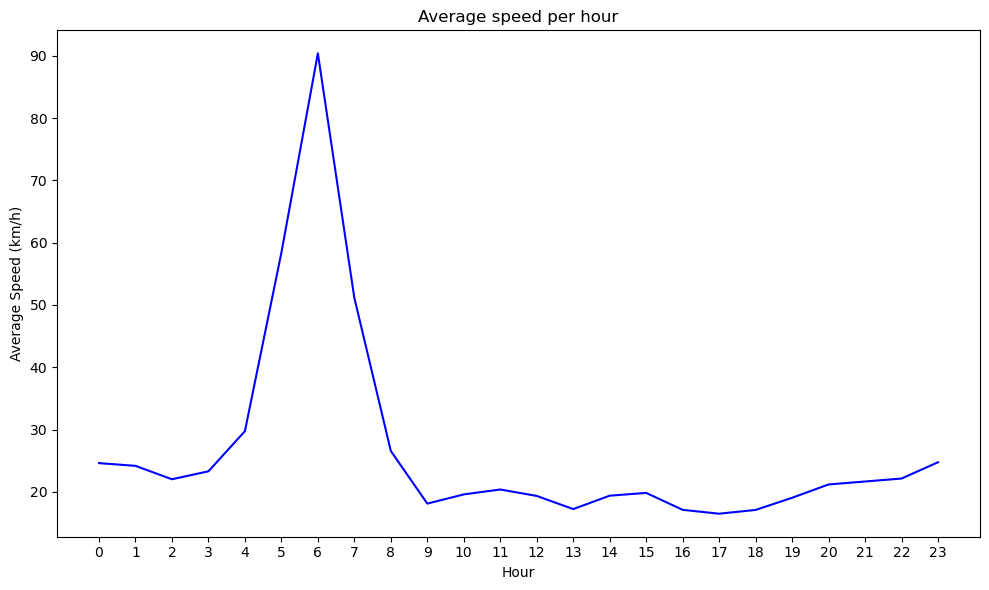

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))

# Line plot, using hours for the x-axis and average speed for the y-axis
sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average Speed (km/h)")
ax.set_title("Average speed per hour")

ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)
#ax.set_yticks(ysticks_)
plt.tight_layout()
plt.show()


**With SQL**

In this section, we will use PySpark SQL to carry out the analysis. By creating a temporary view from our DataFrame, we can run SQL queries to efficiently manipulate and analyze structured data. SQL offers a robust and flexible approach to handling data, allowing us to perform complex aggregations and transformations with ease.

In [24]:
taxi_df = taxi_data_df.alias('taxi_data_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|

In [25]:
# Create temporary views for SQL queries
taxi_data_df.createOrReplaceTempView("taxi_data")

# Use SQL to calculate trip distances in kilometers, duration, speed, and extract hour
sql_query = """
SELECT 
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    ROUND(trip_distance * 1.609344, 3) AS trip_distance_km,
    (UNIX_TIMESTAMP(tpep_dropoff_datetime) - UNIX_TIMESTAMP(tpep_pickup_datetime)) / 3600 AS trip_duration_hours,
    ROUND(ROUND(trip_distance * 1.609344, 3) / ((UNIX_TIMESTAMP(tpep_dropoff_datetime) - UNIX_TIMESTAMP(tpep_pickup_datetime)) / 3600), 3) AS trip_speed_km_h,
    DATE_FORMAT(tpep_pickup_datetime, 'HH') AS hour_time
FROM taxi_data
"""

# Execute the SQL query and create a new DataFrame
taxi_df = spark.sql(sql_query)

# Group by hour and calculate average trip speed
hours_speed_df = taxi_df.groupBy("hour_time").agg({"trip_speed_km_h": "mean"})

# Convert the "hour_time" column to integer type
hours_speed_df = hours_speed_df.withColumn("hour_time", hours_speed_df["hour_time"].cast(IntegerType()))

# Measure execution time for the SQL operation
start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()  # Convert the DataFrame to a Pandas DataFrame for further analysis
end_time = time.time()

# Calculate and print the execution time
task1_spark_sql_time = end_time - start_time

# Amount of data processed
data_processed = taxi_df.count()  # Total number of records in filtered DataFrame

processing_speed = data_processed / task1_spark_sql_time if task1_spark_sql_time > 0 else float('inf')

print(f'Execution time for Spark SQL task: {task1_spark_sql_time:.2f} s')
print(f'Amount of data processed: {data_processed} records')
print(f"Processing Speed: {processing_speed:.2f} records/s")

Execution time for Spark SQL task: 2.09 s
Amount of data processed: 2926246 records
Processing Speed: 1398142.90 records/s


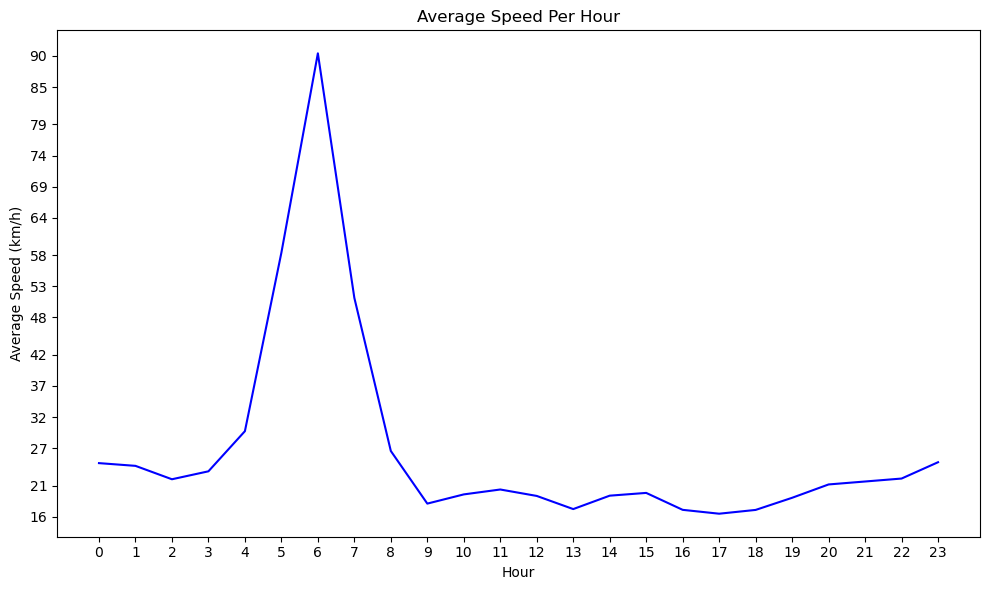

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average Speed (km/h)")
ax.set_title("Average Speed Per Hour")

#x-ticks to represent each hour of the day
ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)

#minimum and maximum average speeds for y-ticks
min_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
max_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
ysticks_ = np.unique(np.round(np.linspace(min_value, max_value, 15)))

ax.set_yticks(ysticks_)
plt.tight_layout()
plt.show()

#### **Conclusions**

- **Peak speed early morning:** The highest average speed, close to 90 km/h, occurs around 6 AM. This could indicate lower traffic congestion during the early morning, allowing taxis to travel faster.

- **Steep decline after 6 AM:** After reaching the peak, there is a rapid decline in average speed around 7 AM, suggesting that traffic starts to build up as people head to work, school, and other activities.

- **Midday slump:** From around 8 AM to 4 PM, the average speed remains relatively low (between 16-30 km/h), indicating heavier traffic during typical working hours, lunch times, and school commutes.

- **Gradual increase late afternoon:** There is a slight increase in speed after 4 PM and continues to rise slightly through 9 PM, which could suggest lighter traffic in the later afternoon and evening hours as people finish work and commute home.

The graph shows that traffic is lightest in the very early morning hours (before 7 AM) and begins to slow down as the day progresses, with speeds staying low for most of the day, particularly during standard commuting hours.

#### **Analysis**

Here we are going to analize the execution time and processing speed on the different processes.
- We are going to compare this task with different number of cores: 1, 2, 4, 6, 8 and 10.

##### **Execution time**

In [3]:
cores = np.array([1, 2, 4, 6, 8, 10])

#here we create the arrays with the value of each measurement for different cores
study1_time_rdd = np.array([73.66, 58.14, 40.02, 40.22, 39.73, 44.00])
study1_time_df = np.array([4.02, 4.08, 2.88, 2.81, 2.98, 1.9])
study1_time_sql = np.array([3.37, 3.04,2.06, 2.27, 2.09, 2.15])
data_cleaning_time = np.array([4.32, 4.04, 3.97, 3.81, 3.85, 4.13])

time_dataframe = dict()
time_dataframe['cores'] = cores
time_dataframe['data_cleaning_time'] = data_cleaning_time
time_dataframe['study1_time_rdd'] = study1_time_rdd
time_dataframe['study1_time_df'] = study1_time_df
time_dataframe['study1_time_sql'] = study1_time_sql

time_dataframe = pd.DataFrame(time_dataframe)

print(time_dataframe)

   cores  data_cleaning_time  study1_time_rdd  study1_time_df  study1_time_sql
0      1                4.32            73.66            4.02             3.37
1      2                4.04            58.14            4.08             3.04
2      4                3.97            40.02            2.88             2.06
3      6                3.81            40.22            2.81             2.27
4      8                3.85            39.73            2.98             2.09
5     10                4.13            44.00            1.90             2.15


In the following plot we can see the difference between RDD, dataframes and SQL, in terms of excecution time depending on the number of cores used

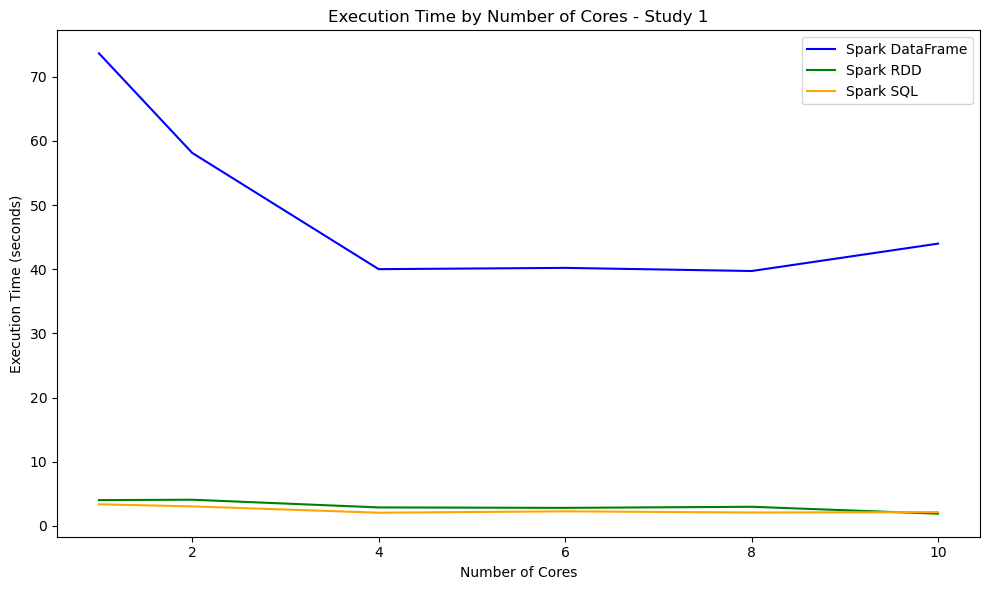

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='cores', y='study1_time_rdd', data=time_dataframe, ax=ax, color='blue', label='Spark DataFrame')
sns.lineplot(x='cores', y='study1_time_df', data=time_dataframe, ax=ax, color='green', label='Spark RDD')
sns.lineplot(x='cores', y='study1_time_sql', data=time_dataframe, ax=ax, color='orange', label='Spark SQL')

ax.set_xlabel("Number of Cores")
ax.set_ylabel("Execution Time (seconds)")
ax.set_title("Execution Time by Number of Cores - Study 1")

ax.tick_params(axis='x', rotation=0)

ax.legend()
fig.tight_layout()

plt.show()

##### **Processing speed**

In [8]:
cores = np.array([1, 2, 4, 6, 8, 10])

#here we create the arrays with the value of each measurement for different cores
study1_speed_rdd = np.array([39725.23, 50331.66, 73114.01, 72750.13, 73656.56, 66500.6])
study1_speed_df = np.array([728360.48, 717991.48, 1016545.86, 1040350.95, 981565.86, 1537907.21])
study1_speed_sql = np.array([868986.07, 963308.4, 1419980.42, 1291148.7, 1398142.9, 1357891.9])

speed_dataframe = dict()
speed_dataframe['cores'] = cores
speed_dataframe['study1_speed_rdd'] = study1_speed_rdd
speed_dataframe['study1_speed_df'] = study1_speed_df
speed_dataframe['study1_speed_sql'] = study1_speed_sql

speed_dataframe = pd.DataFrame(speed_dataframe)

# Set width of bars
bar_width = 0.25

# Set position of bars on X axis
x = np.arange(len(tasks))print(speed_dataframe)

   cores  study1_speed_rdd  study1_speed_df  study1_speed_sql
0      1          39725.23        728360.48         868986.07
1      2          50331.66        717991.48         963308.40
2      4          73114.01       1016545.86        1419980.42
3      6          72750.13       1040350.95        1291148.70
4      8          73656.56        981565.86        1398142.90
5     10          66500.60       1537907.21        1357891.90


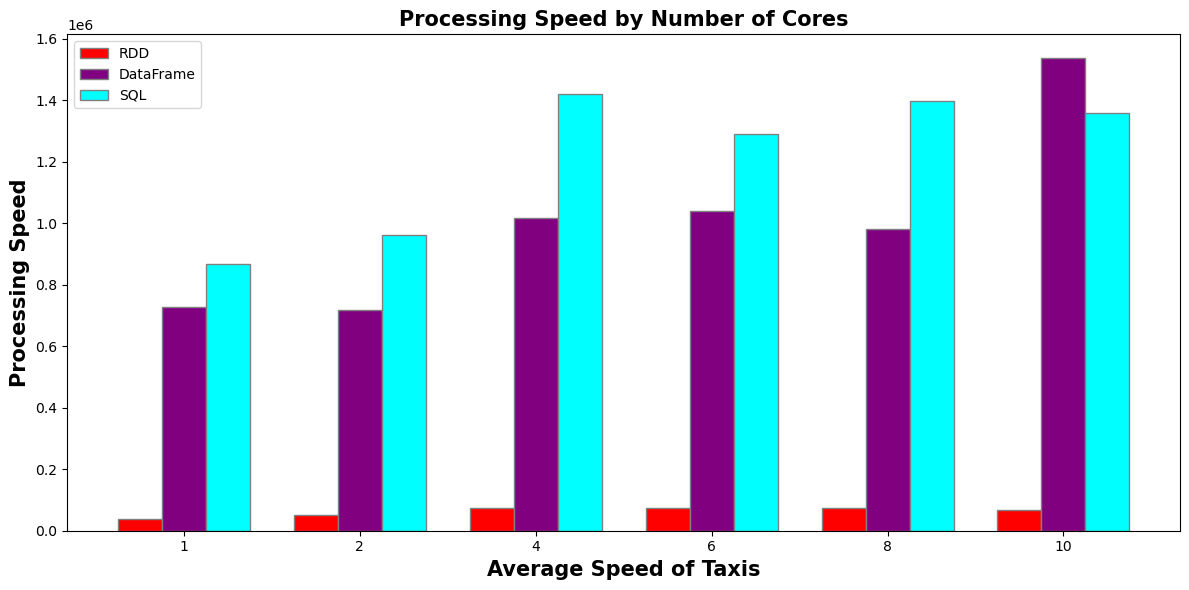

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Arrays con los datos
cores = np.array([1, 2, 4, 6, 8, 10])

# Velocidad de procesamiento para cada método
study1_speed_rdd = np.array([39725.23, 50331.66, 73114.01, 72750.13, 73656.56, 66500.6])
study1_speed_df = np.array([728360.48, 717991.48, 1016545.86, 1040350.95, 981565.86, 1537907.21])
study1_speed_sql = np.array([868986.07, 963308.4, 1419980.42, 1291148.7, 1398142.9, 1357891.9])

# Crear el DataFrame para visualizar los datos (opcional, no necesario para el gráfico)
speed_dataframe = pd.DataFrame({
    'cores': cores,
    'study1_speed_rdd': study1_speed_rdd,
    'study1_speed_df': study1_speed_df,
    'study1_speed_sql': study1_speed_sql
})

# Set width of bars
bar_width = 0.25

# Set position of bars on X axis
x = np.arange(len(cores))

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, study1_speed_rdd, color='red', width=bar_width, edgecolor='grey', label='RDD')
plt.bar(x, study1_speed_df, color='purple', width=bar_width, edgecolor='grey', label='DataFrame')
plt.bar(x + bar_width, study1_speed_sql, color='cyan', width=bar_width, edgecolor='grey', label='SQL')

# Etiquetas y título
plt.xlabel('Average Speed of Taxis', fontweight='bold', fontsize=15)
plt.ylabel('Processing Speed', fontweight='bold', fontsize=15)
plt.title('Processing Speed by Number of Cores', fontweight='bold', fontsize=15)

# Etiquetas del eje X
plt.xticks(x, cores)

# Añadir la leyenda
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


We have also calculated the speed-up of all processes. This is done by dividing the execution time of one core by the execution time of all cores.

In [5]:
df_speed_up = pd.DataFrame()

df_speed_up['cores'] = time_dataframe['cores']

for column in time_dataframe.drop(columns='cores'):
    one_core_time = time_dataframe[time_dataframe['cores'] == 1][column].values[0]
    speed_up_values = time_dataframe[column].apply(lambda x: one_core_time / x)
    df_speed_up[column] = speed_up_values

print(df_speed_up)

   cores  data_cleaning_time  study1_time_rdd  study1_time_df  study1_time_sql
0      1            1.000000         1.000000        1.000000         1.000000
1      2            1.069307         1.266942        0.985294         1.108553
2      4            1.088161         1.840580        1.395833         1.635922
3      6            1.133858         1.831427        1.430605         1.484581
4      8            1.122078         1.854015        1.348993         1.612440
5     10            1.046005         1.674091        2.115789         1.567442


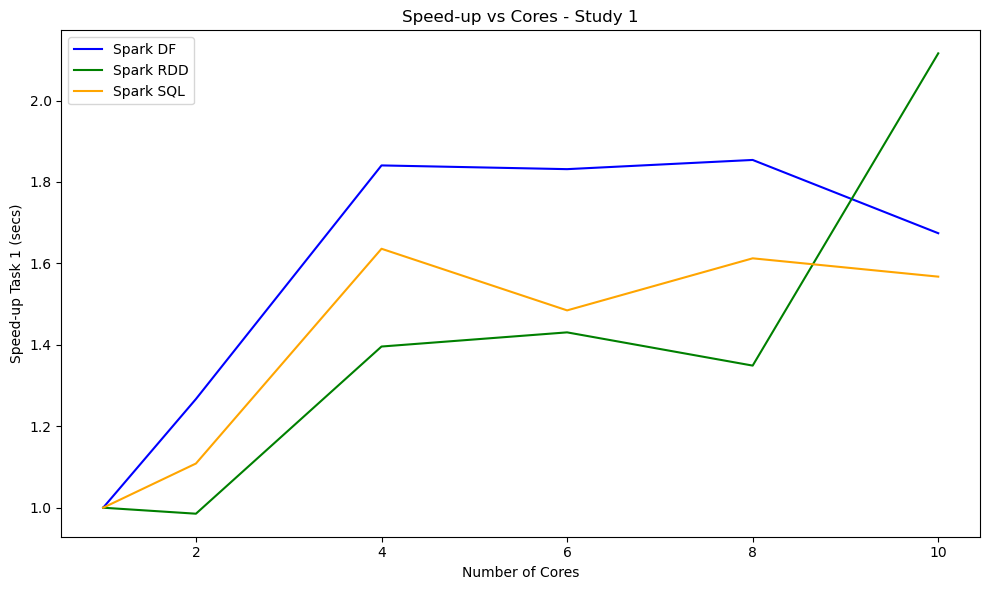

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x='cores', y='study1_time_rdd', data=df_speed_up, ax=ax, color='blue', label='Spark DF')
sns.lineplot(x='cores', y='study1_time_df', data=df_speed_up, ax=ax, color='green', label='Spark RDD')
sns.lineplot(x='cores', y='study1_time_sql', data=df_speed_up, ax=ax, color='orange', label='Spark SQL')

ax.set_xlabel("Number of Cores")
ax.set_ylabel("Speed-up Task 1 (secs)")
ax.set_title("Speed-up vs Cores - Study 1")

ax.tick_params(axis='x', rotation=0)
ax.legend()
plt.tight_layout()
plt.show()

### **STUDY 2: MOST COMMON TAXI TRIPS**

In this study, we examined the most common taxi rides, using Spark Dataframe for our analysis. We have also used the file "taxi_zone_lookup.csv" that provides us more information about the zones from the taxi trips.

We are going to filter the unknown trips in the "taxi_zone_lookup.csv" file and then gruop by pickup and dropoff location ids. Both datasets are going to be joined.

In [31]:
zones_df = (spark.read.format("csv").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(r"./taxi_zone_lookup.csv"))

filter_zones_df = zones_df.filter(col('LocationID') < 264)

# Group taxis data by Pickup and Dropoff Location IDs and count trips
grouped_taxis_df = (taxi_data_df.groupBy('PULocationID', 'DOLocationID')
                    .agg(count('*').alias('trip_count'))
                    .orderBy(col('trip_count').desc()))

# Inner join for Pickup locations
PU_joined_df = (grouped_taxis_df
    .join(filter_zones_df, grouped_taxis_df['PULocationID'] == filter_zones_df['LocationID'], 'inner')
    .select('PULocationID', 'DOLocationID', 'LocationID', 'trip_count', 'Borough', 'Zone')
    .withColumnRenamed('Borough', 'Borough_PU')
    .withColumnRenamed('Zone', 'Zone_PU')
    .withColumnRenamed('trip_count', 'trip_count_PU'))

# Inner join for Dropoff locations
DO_joined_df = (grouped_taxis_df
    .join(filter_zones_df, grouped_taxis_df['DOLocationID'] == filter_zones_df['LocationID'], 'inner')
    .select('PULocationID', 'DOLocationID', 'LocationID', 'trip_count', 'Borough', 'Zone')
    .withColumnRenamed('Borough', 'Borough_DO')
    .withColumnRenamed('Zone', 'Zone_DO'))

# Combine the two joined DataFrames on Pickup and Dropoff locations
zones_trips_df = (PU_joined_df.join(DO_joined_df, (PU_joined_df['PULocationID'] == DO_joined_df['PULocationID']) & (PU_joined_df['DOLocationID'] == DO_joined_df['DOLocationID']), 'inner').select('Borough_PU', 'Zone_PU', 'Borough_DO', 'Zone_DO', 'trip_count'))

# Sort the final DataFrame by trip_count in descending order
sorted_zones_trips_df = zones_trips_df.orderBy(col('trip_count').desc())

start_time = time.time()
sorted_zones_trips_df.show(10)
end_time = time.time()
study2_df_time = end_time - start_time

# Amount of data processed
data_processed = grouped_taxis_df.count()  # Total number of records in the original DataFrame

# Processing speed (records per second)
processing_speed = data_processed / study2_df_time if study2_df_time > 0 else float('inf')

print(f'Execution time for Spark dataframes task: {study2_df_time:.2f} s')
print(f'Amount of data processed: {data_processed} records')
print(f"Processing Speed: {processing_speed:.2f} records/s")

+----------+--------------------+----------+--------------------+----------+
|Borough_PU|             Zone_PU|Borough_DO|             Zone_DO|trip_count|
+----------+--------------------+----------+--------------------+----------+
| Manhattan|Upper East Side S...| Manhattan|Upper East Side N...|     21708|
| Manhattan|Upper East Side N...| Manhattan|Upper East Side S...|     19269|
| Manhattan|Upper East Side N...| Manhattan|Upper East Side N...|     15626|
| Manhattan|Upper East Side S...| Manhattan|Upper East Side S...|     14559|
| Manhattan|      Midtown Center| Manhattan|Upper East Side S...|     10170|
| Manhattan| Lincoln Square East| Manhattan|Upper West Side S...|      8883|
| Manhattan|Upper East Side S...| Manhattan|      Midtown Center|      8752|
| Manhattan|      Midtown Center| Manhattan|Upper East Side N...|      8703|
| Manhattan|Upper West Side S...| Manhattan| Lincoln Square East|      8595|
| Manhattan|Upper West Side S...| Manhattan|Upper West Side N...|      8366|

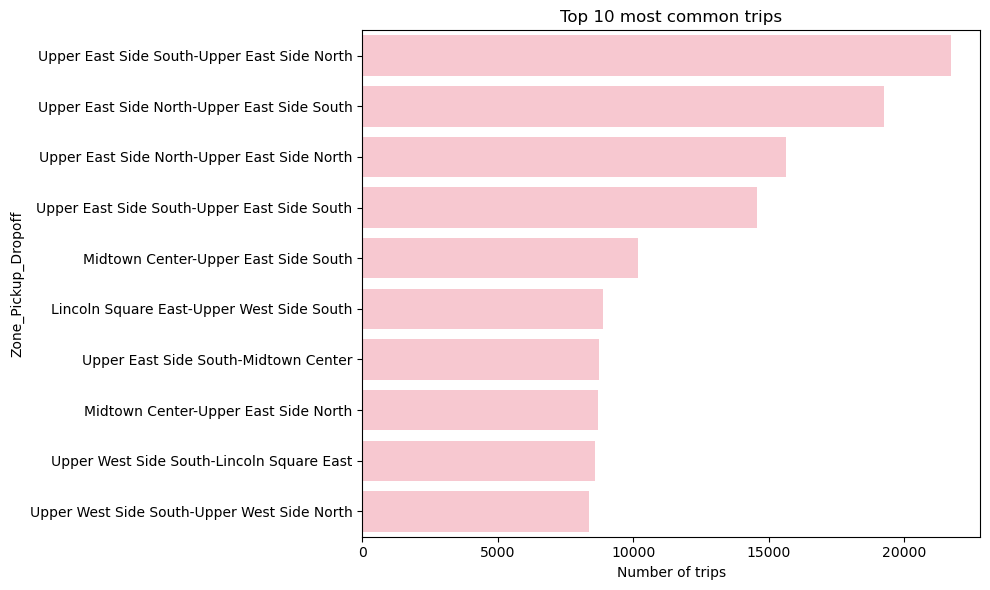

In [32]:
sorted_zones_trips_df = sorted_zones_trips_df.withColumn('Zone_Pickup_Dropoff', concat(col('Zone_PU'), lit('-'), col('Zone_DO')))
sorted_zones_trips_df_pandas = sorted_zones_trips_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(y="Zone_Pickup_Dropoff", x="trip_count", data=sorted_zones_trips_df_pandas.head(10), color='pink')
plt.xlabel("Number of trips")
plt.ylabel("Zone_Pickup_Dropoff")
plt.title("Top 10 most common trips")
plt.xticks(rotation=0) 
plt.tight_layout()
plt.show()

#### **Conclusions**

- **Frequent travel between Upper East Side zones:** The top four most common trips all involve Upper East Side South and North locations. This suggests that a large portion of taxi activity is concentrated in this area, likely due to high residential and business activity.

- **Upper East Side dominance:** Out of the top 10 trips, most of them start or end in the Upper East Side region, indicating it is a major hub for taxi trips.

- **Midtown Center:** Midtown Center also appears in a few of the top routes, signifying that this area—likely due to business and tourist activity—sees significant taxi traffic, particularly to and from the Upper East Side.

- **Upper West Side:** Some trips also connect the Upper West Side (South or North) to other prominent areas like Lincoln Square East or Upper East Side North, showing the importance of this area in taxi routes.

- **Short-distance trips:** The trips seem to be short-distance routes within central Manhattan neighborhoods. This pattern is consistent with the dense urban environment where taxis are frequently used for short commutes within specific zones rather than longer, cross-borough trips.

### **STUDY 3: FINANCIAL RECORDS: AVERAGE TIPS PER BOROUGH**

We have merged both datasets, trips and zones, to obtain the borough and the average trip amount, excluding unknown zones. Group the results by borough and sort by average trip amount.

In [33]:
filtered_zones_df = zones_df.filter(col('LocationID') < 264)
join_df = taxi_data_df.join(filtered_zones_df, taxi_data_df['PULocationID'] == filtered_zones_df['LocationID']) \
                  .groupBy('Borough') \
                  .agg(avg('tip_amount').alias('tip_amount_avg')) \
                  .orderBy(col('tip_amount_avg').desc())

start_time = time.time()
join_df.show(10)
end_time = time.time()

task3_spark_sql_time = end_time - start_time

data_processed = join_df.count() 
processing_speed = data_processed / task3_spark_sql_time if task3_spark_sql_time > 0 else float('inf')


print(f"Execution Time: {task3_spark_sql_time:.2f} seconds")
print(f"Total Records Processed: {data_processed} records")
print(f"Processing Speed: {processing_speed:.2f} records/second")

+-------------+-------------------+
|      Borough|     tip_amount_avg|
+-------------+-------------------+
|          EWR| 13.185583038869261|
|       Queens|  8.360322458397695|
|Staten Island|  4.004029850746268|
|    Manhattan|  2.891192287740158|
|     Brooklyn|  1.616190629140402|
|        Bronx|0.30636695906432754|
+-------------+-------------------+

Execution Time: 1.69 seconds
Total Records Processed: 6 records
Processing Speed: 3.54 records/second


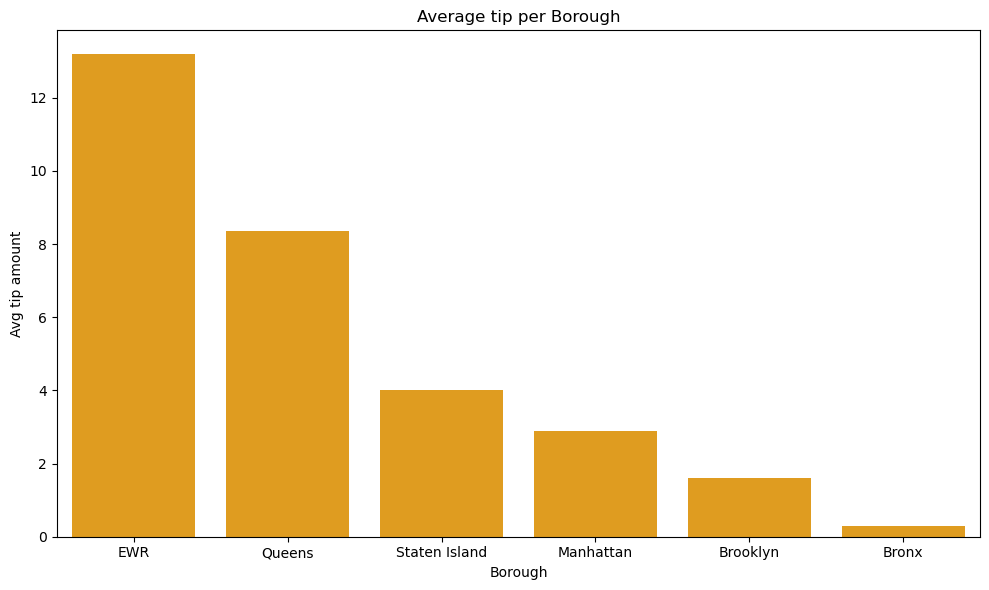

In [34]:
join_df_pd = join_df.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="Borough", y="tip_amount_avg", data=join_df_pd, color='orange')
plt.xlabel("Borough")
plt.ylabel("Avg tip amount")
plt.title("Average tip per Borough") 
plt.tight_layout()
plt.show()


#### **Conclusions**

- **EWR as the highest average tip:** The EWR (Newark Liberty International Airport) shows a significantly higher average tip amount compared to other boroughs, with tips exceeding $12. This could indicate that trips to and from the airport generally involve higher fares, leading to larger tips from passengers.

- **Queens and Staten Island:** Both Queens and Staten Island have notable average tip amounts, with Queens slightly higher than Staten Island. This suggests that passengers in these boroughs also tend to give relatively generous tips.

- **Manhattan's position:** While Manhattan is typically a high-traffic area for taxis, its average tip amount is lower than that of EWR, Queens, and Staten Island, indicating that while fares might be high, passengers may not be tipping as generously.

- **Lower tips in other boroughs:** Brooklyn and Bronx have the lowest average tip amounts, suggesting that passengers in these areas might either be tipping less or that trips in these boroughs may generally involve shorter distances and lower fares, resulting in smaller tips.

- **Potential influences:** The average tip amounts may reflect various factors, including the socioeconomic demographics of each borough, the nature of trips (e.g., airport trips versus local commutes), and the overall quality of service provided.

### **STUDY 4: FINANCIAL RECORDS: AVERAGE TAXI FARE PER HOUR**

In this study we are analyzing the variation of taxi fares throughout the day.

In [35]:
start_time = time.time()

# SQL query
average_fare_query = """
SELECT 
    hour(tpep_pickup_datetime) AS pickup_hour,
    AVG(fare_amount) AS average_fare
FROM 
    taxi_data
WHERE 
    fare_amount > 0 
GROUP BY 
    pickup_hour
ORDER BY 
    pickup_hour
"""

average_fare_results = spark.sql(average_fare_query).collect()

end_time = time.time()
execution_time = end_time - start_time  # Time in seconds

print("Average Taxi Fare Per Hour:")
for record in average_fare_results:
    print(f"Hour {record.pickup_hour}: ${record.average_fare:.2f}")

data_processed = taxi_data_df.count()  # Total number of records processed
processing_speed = data_processed / execution_time if execution_time > 0 else float('inf')

print(f"Execution Time: {execution_time:.2f} seconds")
print(f"Total Records Processed: {data_processed} records")
print(f"Processing Speed: {processing_speed:.2f} records/second")


Average Taxi Fare Per Hour:
Hour 0: $19.92
Hour 1: $18.17
Hour 2: $17.13
Hour 3: $19.02
Hour 4: $23.70
Hour 5: $27.69
Hour 6: $22.20
Hour 7: $18.90
Hour 8: $17.98
Hour 9: $18.06
Hour 10: $18.15
Hour 11: $17.82
Hour 12: $17.92
Hour 13: $18.56
Hour 14: $19.39
Hour 15: $19.26
Hour 16: $19.62
Hour 17: $18.28
Hour 18: $17.17
Hour 19: $17.78
Hour 20: $18.20
Hour 21: $18.46
Hour 22: $19.25
Hour 23: $20.44
Execution Time: 1.48 seconds
Total Records Processed: 2926246 records
Processing Speed: 1983363.22 records/second


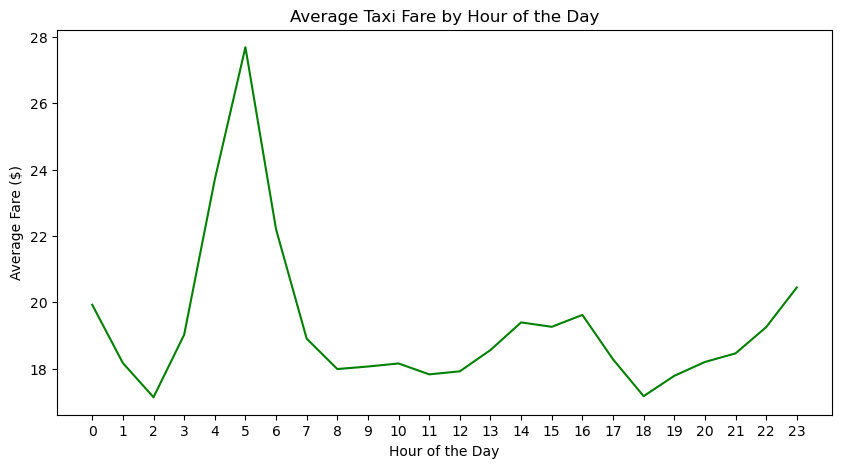

In [36]:
hours = [hour for hour, _ in average_fare_results]
avg_fares = [fare for _, fare in average_fare_results]

plt.figure(figsize=(10, 5))
plt.plot(hours, avg_fares, color='green', linestyle='-')
plt.title("Average Taxi Fare by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Average Fare ($)")
plt.xticks(range(0, 24)) 
plt.show()

#### **Conclusions**

- **Peak fare times:** There is a sharp spike in fares around 4 AM to 5 AM, where the average fare reaches its maximum, suggesting higher demand or longer trips during this period. This might correspond to late-night trips, airport runs, or fewer taxis being available, causing prices to surge.

- **Lowest fares:** The fares dip to their lowest between 7 AM and 8 AM, then again between 16 PM and 17 PM, suggesting that these are periods of the day when taxi demand may be lower or trips are shorter, possibly due to commuters using alternative transport modes during rush hour.

- **General trend:** After the peak at 4-5 AM, the fares gradually decrease until mid-morning, after which they remain relatively stable until around 20:00, when there's a slight increase towards the late evening.

- **Late-Night uptick:** After 8 PM, the fares start rising again, though not as steeply as the early morning peak, possibly reflecting increased demand from evening activities like dinners or nightlife.

#### **FINAL CONCLUSIONS**

After analyzing the execution time, data processed, and processing speed across different studies using RDDs, DataFrames, and SQL in PySpark, we can derive several additional conclusions:

1. **Execution Time:**

- DataFrames and SQL consistently showed faster execution times compared to RDDs. The optimizations within the Spark engine made DataFrames and SQL much quicker for processing large volumes of data.
- RDDs generally had longer execution times due to the need for more explicit transformations and the absence of internal optimizations available with DataFrames and SQL.
  
2. **Data Processed:**

- Across all methods, Spark’s distributed nature allowed the efficient processing of vast amounts of data. However, the structured format of DataFrames and SQL allowed them to handle more significant amounts of structured data more easily compared to RDDs, which are better suited for unstructured or semi-structured data.

3. **Processing Speed:**

- DataFrames and SQL exhibited superior processing speed in terms of records processed per second, mainly due to Spark's internal optimization engine. DataFrames could take advantage of Spark's efficient memory usage and execution strategies.
- RDDs, while versatile and offering more control, showed lower processing speed as they required more manual operations and didn’t benefit from the high-level optimizations.

Overall, for large-scale data processing tasks, the processing speed and execution time were best optimized using DataFrames and SQL, making them the preferable choice for most scenarios where performance is a priority. However, RDDs still hold value when more granular control is needed, though at the cost of lower speed.